/home/bmb41/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


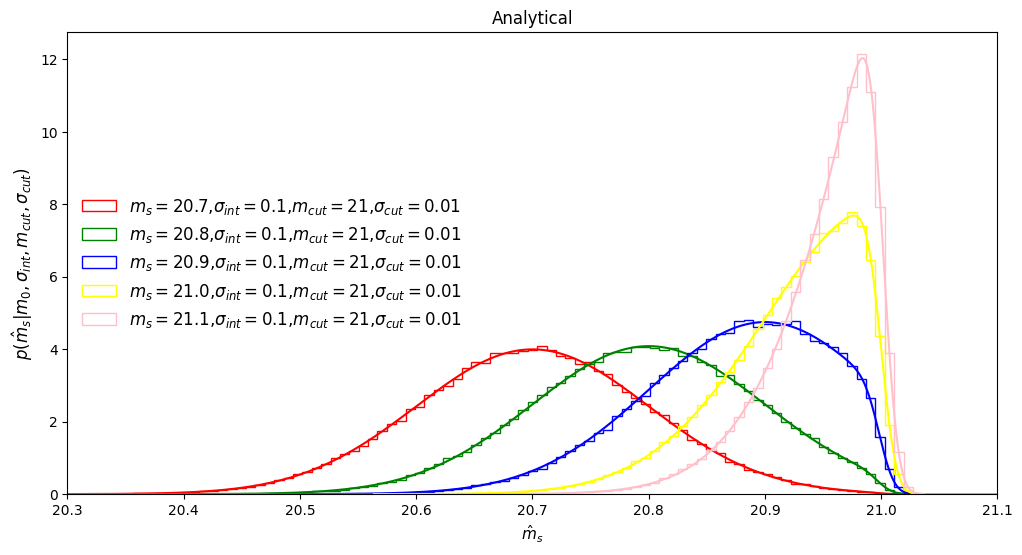

In [1]:
from SkewNormalPlus import SkewNormalPlus
from matplotlib import pyplot as plt
import jax.random as random
import jax.numpy as jnp

import numpy as np
from scipy.stats import norm

seed=21

mu=np.array([20.7,20.8,20.9,21,21.1])
sigma_int=0.1
sigma_cut=0.01
mu_cut= 21



rng_key = random.PRNGKey(seed)


snp = SkewNormalPlus(m_int=mu,sigma_int=sigma_int,m_cut=mu_cut,sigma_cut=sigma_cut)

c=['red','green','blue','yellow','pink']
samps=snp.sample(rng_key,(100000,5))
plt.figure(figsize=(12,6))



sor = jnp.sort(samps,axis=0)

pro =jnp.exp(snp.log_prob(sor))
bins=np.linspace(20.3,21.1,100)

for i in range(samps.shape[1]):

    plt.hist(samps[:,i],bins=bins,density=True,histtype='step',color=c[i],label='$m_s=$'+str(mu[i])+',$\sigma_{int}=$'+str(sigma_int)+',$m_{cut}=$'+str(mu_cut)+',$\sigma_{cut}=$'+str(sigma_cut))


    plt.plot(sor[:,i],pro[:,i],color=c[i])


n = norm(-mu_cut,sigma_cut)



#plt.plot(jnp.linspace(19.5,20.2,100),n.cdf(-jnp.linspace(19.5,20.2,100))*13,label='const$\cdot CDF(\hat{m}_s|m_{cut},\sigma_{cut})$',color='black',linestyle='--')



plt.xlim(20.3,21.1)
plt.legend(loc='center left',frameon=False,fontsize=12)
plt.xlabel('$\hat{m}_s$',fontsize=11)
plt.ylabel('$p(\hat{m}_s|m_0,\sigma_{int},m_{cut},\sigma_{cut})$',fontsize=12)
plt.title('Analytical')



plt.show()


In [2]:
import numpy as np
from matplotlib import pyplot as plt
import numpyro
from numpyro.infer import MCMC, NUTS, Predictive
import numpyro.distributions as dist
from numpyro.diagnostics import hpdi
from jax import random
import jax
from jax.example_libraries import stax, optimizers
from jax.scipy.stats import norm
from jax.scipy.special import ndtri
#assert numpyro.__version__.startswith("0.11.0")

numpyro.set_host_device_count(4)
jax.config.update('jax_enable_x64',True)


import jax_cosmo as jc
from jax_cosmo import Cosmology, background

from astropy.cosmology import FlatLambdaCDM,wCDM
from astropy.coordinates import Distance

from numpyro import sample

import numpyro.distributions as dist

import jax.numpy as jnp
from jax import grad, jit, vmap, value_and_grad
from numpyro.distributions.truncated import TruncatedDistribution 
from numpyro.distributions import (
    Distribution,
    constraints)
from numpyro.distributions.util import is_prng_key, promote_shapes, validate_sample
from jax import lax
from SkewNormalPlus import SkewNormalPlus

In [3]:

import numpyro
from NSF import NeuralSpline1D
from flow import Normal,Flow,transform,Serial
from SkewNormalPlus import SkewNormalPlus as snp

@jit
def minmax_fit_and_scale(X):
  max= jnp.max(X,axis=0)
  min = jnp.min(X,axis=0)
  X_std = (X - min) / (max-min)
  return X_std,min,max

@jit
def minmax_scale(X,min,max):
  return (X - min) / (max - min)

@jit
def minmax_unscale(X,min,max):
  return X * (max - min) + min

from jax.example_libraries import stax, optimizers

from jax.example_libraries.stax import (Dense, Tanh, Flatten, Relu, LogSoftmax, Softmax, Exp,Sigmoid,Softplus,LeakyRelu)

def network(rng,conditional_dim,out_dim, hidden_dim):
    init_fun,apply_fun=stax.serial(stax.Dense(hidden_dim), Relu, stax.Dense(1024),  Relu, stax.Dense(1024),Relu,stax.Dense(hidden_dim), Relu, stax.Dense(out_dim),)
    _, params = init_fun(rng, (conditional_dim,))

    return params,apply_fun

rng, flow_rng = random.split(random.PRNGKey(0))

init_fun = Flow(Serial(*(NeuralSpline1D(network,hidden_dim=256,K=40,B=5),)*5),prior=Normal())

_, log_pdf_flow, sample_flow = init_fun(flow_rng,2 )



In [4]:
file = jnp.load('flow2d.npz',allow_pickle=True)
opt_init, opt_update, get_params = optimizers.adam(step_size=5e-3)

opt_params = pickle.load(open('flow2d_opt.pkl', "rb"))
opt_state = optimizers.pack_optimizer_state(opt_params)

params = get_params(opt_state)



min_file = jnp.asarray(file['min'])
max_file = jnp.asarray(file['max'])

class FlowSNP(Distribution):
    arg_constraints = {"m_int": constraints.real, "sigma_int": constraints.real,"m_cut": constraints.real, "sigma_cut": constraints.real}
    support = constraints.real
    reparametrized_params = ["m_int", "sigma_int","m_cut","sigma_cut"]

    def __init__(self,m_int,sigma_int,m_cut,sigma_cut,*, validate_args=None,res=1000):
        
 
        self.min = min_file
        self.max = max_file

        

        
        self.m_int, self.sigma_int,self.m_cut,self.sigma_cut = promote_shapes(m_int,sigma_int,m_cut,sigma_cut)


        batch_shape = lax.broadcast_shapes(jnp.shape(m_int), jnp.shape(sigma_int),jnp.shape(m_int), jnp.shape(sigma_int))
        
        n_obj = m_int.shape[0]
        
        
        self.n_obj=n_obj
        


        super(FlowSNP, self).__init__(
            batch_shape=batch_shape, validate_args=validate_args
        )
        

    def sample(self,key, sample_shape=()):
        assert is_prng_key(key)
        
        
        
        no_samps = sample_shape[0]
        
        self.no_samps = no_samps
        
        theta = jnp.column_stack((jnp.repeat(self.m_int.reshape(self.n_obj),no_samps).reshape(no_samps*self.n_obj,1),jnp.repeat(self.sigma_int,no_samps*self.n_obj).reshape(no_samps*self.n_obj,1)))
        
        samp=sample_flow(key, params,minmax_scale(theta,jnp.asarray(self.min[1:]),np.asarray(self.max[1:])),num_samples=self.no_samps*self.n_obj)
        
        samp = minmax_unscale(samp[:,0],self.min[0],self.max[0])
        
        
        
        return samp.reshape(self.n_obj,self.no_samps).T

    
    @jax.jit
    def log_prob(self, value):
        
        no_samps = value.shape[0]
        no_obj = value.shape[1]
        
        
        value=value.T.reshape(no_samps*no_obj,)
        value = value.reshape(no_samps*no_obj,1)
        
        
        
        theta=jnp.column_stack((self.m_int.reshape(no_obj,1),jnp.repeat(self.sigma_int,no_obj).reshape(no_obj,1)))       
        
        theta = jnp.repeat(theta,no_samps,axis=0)

        
        X=jnp.asarray(minmax_scale(jnp.column_stack((value,theta)),self.min,self.max))
            
        
        prob = log_pdf_flow(params,X)
        prob = prob.reshape(no_obj*no_samps,)
        prob=prob.reshape(no_obj,no_samps).T
        

        return prob




NameError: name 'pickle' is not defined

In [ ]:
u=random.uniform(random.PRNGKey(100),(100,))*0.5+20.5


snp= SkewNormalPlus(u,0.1,21,0.01)

seed=1701

rng_key = jax.random.PRNGKey(seed)

m_s=snp.sample(rng_key,(1000,100))


In [ ]:
from SkewNormalPlus import SkewNormalPlus
from matplotlib import pyplot as plt
import jax.random as random
import jax.numpy as jnp

import numpy as np
from scipy.stats import norm

seed=21

mu=jnp.array([20.7,20.8,20.9,21,21.1])
sigma_int=0.1
sigma_cut=0.01
mu_cut= 21



rng_key = random.PRNGKey(seed)


snp = FlowSNP(m_int=mu,sigma_int=sigma_int,m_cut=mu_cut,sigma_cut=sigma_cut)

c=['red','green','blue','yellow','pink']
samps=snp.sample(rng_key,(100000,5))

bins=np.linspace(20.3,21.1,100)
trial= np.repeat(bins.reshape(100,1),5,axis=1)


log_pro = snp.log_prob(jnp.asarray(trial))




plt.figure(figsize=(12,6))


for i in range(samps.shape[1]):

    plt.hist(samps[:,i],bins=bins,density=True,histtype='step',color=c[i],label='$m_s=$'+str(mu[i])+',$\sigma_{int}=$'+str(sigma_int)+',$m_{cut}=$'+str(mu_cut)+',$\sigma_{cut}=$'+str(sigma_cut))

    prob=np.exp(log_pro[:,i])

    plt.plot(bins,prob,color=c[i])





plt.xlim(20.3,21.1)
plt.legend(loc='center left',frameon=False,fontsize=12)
plt.xlabel('$\hat{m}_s$',fontsize=11)
plt.ylabel('$p(\hat{m}_s|m_0,\sigma_{int},m_{cut},\sigma_{cut})$',fontsize=12)
plt.title('Analytical')



plt.show()


In [ ]:
for i in range(samps.shape[1]):

    plt.hist(samps[:,i],bins=1000,density=True,histtype='step',color=c[i],label='$m_s=$'+str(mu[i])+',$\sigma_{int}=$'+str(sigma_int)+',$m_{cut}=$'+str(mu_cut)+',$\sigma_{cut}=$'+str(sigma_cut))

    
plt.show()

In [ ]:

bins=np.linspace(20.6,21,1000)


for i in range(samps.shape[1]):

    snp = FlowSNP(m_int=jnp.array([mu[i]]),sigma_int=sigma_int,m_cut=mu_cut,sigma_cut=sigma_cut)

    log_prob1=snp.log_prob(bins)-0.5
    
    
    snp = SkewNormalPlus(m_int=jnp.array([mu[i]]),sigma_int=sigma_int,m_cut=mu_cut,sigma_cut=sigma_cut)

    log_prob2=snp.log_prob(bins)
    
    
    plt.plot(bins,log_prob2-log_prob1,color=c[i])
    
    